# Problem Definition

## Business Context

**EnergyCo** is a leading utility company that provides electricity to millions of households. In the era of smart technologies and increasing emphasis on energy sustainability, accurate forecasting of household energy consumption has become paramount. EnergyCo aims to enhance its services and operational efficiency by implementing a **Smart Energy Management System (SEMS)**. A core component of SEMS is the ability to **forecast individual household energy consumption** accurately.

## Problem Statement

EnergyCo seeks to predict each household's energy consumption to optimize its Smart Energy Management System. Accurate energy consumption forecasts will enable EnergyCo to make informed decisions in the following areas:

- **Energy Distribution:** Efficiently allocate energy resources to meet varying demand, preventing overloading and reducing energy wastage.
- **Dynamic Pricing Models:** Implement pricing strategies that reflect real-time energy demand, encouraging energy conservation during peak hours.
- **Customer Engagement Strategies:** Provide personalized energy-saving recommendations to households based on their usage patterns, enhancing customer satisfaction and loyalty.
- **Demand Response Programs:** Initiate programs that adjust energy usage during high-demand periods, ensuring grid stability and reliability.

## Objective

- **Type of Task:** Regression
- **Goal:** Develop a predictive model to forecast the active energy consumed every minute (in kilowatt) in the household

## Success Criteria

To evaluate the effectiveness of the energy consumption forecasting model, the following success criteria and evaluation metrics will be employed:

### Evaluation Metrics

1. **Mean Absolute Error (MAE):** Measures the average magnitude of errors in the predictions without considering their direction. Lower MAE indicates higher accuracy.
   
2. **Mean Squared Error (MSE):** Measures the average of the squares of the errors, penalizing larger errors more severely than MAE.
   
3. **Root Mean Squared Error (RMSE):** Provides the square root of MSE, giving an error magnitude in the same units as the target variable. Lower RMSE signifies better model performance.
   
4. **R² Score (Coefficient of Determination):** Indicates the proportion of variance in the target variable that is predictable from the feature variables. An R² score closer to 1 denotes a model that explains a large portion of the variance.

### Performance Goals

- **RMSE:** Aim to achieve the lowest possible RMSE to ensure high predictive accuracy of the model.
  
- **R² Score:** Strive for an R² score as close to 1 as possible, indicating that the model effectively captures the variability in energy consumption data.

In [1]:
# import necessary libraries
import pandas as pd
from scipy.stats import zscore, skew
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scripts import *

In [2]:
# Load dataset
file_path = "household_power_consumption.csv"
nrows = 500000
dataset = pd.read_csv(file_path, low_memory=False, nrows=nrows)
dataset.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


## Data Exploration and Preparation

## Data Cleaning

#### A. Handle Missing Values

In [3]:
# identify missing values
missing_values = dataset.isnull().sum()
print("Missing Values in Each Column:\n", missing_values)

Missing Values in Each Column:
 Date                        0
Time                        0
Global_active_power         0
Global_reactive_power       0
Voltage                     0
Global_intensity            0
Sub_metering_1              0
Sub_metering_2              0
Sub_metering_3           3933
dtype: int64


In [4]:
# remove columns containing missing values
dataset = dataset.dropna()

print(f"Dataset Shape After Dropping Rows with Any Missing Values: {dataset.shape}")

print("Missing Values After Dropping Rows:\n", dataset.isnull().sum())

Dataset Shape After Dropping Rows with Any Missing Values: (496067, 9)
Missing Values After Dropping Rows:
 Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


#### B. Correct Data Types

In [5]:
# Convert 'Date' and 'Time' to datetime
dataset['DateTime'] = pd.to_datetime(dataset['Date'] + ' ' + dataset['Time'], format='%d/%m/%Y %H:%M:%S')

# Drop the original 'Date' and 'Time' columns if no longer needed
dataset.drop(['Date', 'Time'], axis=1, inplace=True)

In [6]:
# Convert numerical columns to float
numerical_cols = ['Global_active_power', 'Global_reactive_power', 'Voltage',
                  'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
dataset[numerical_cols] = dataset[numerical_cols].astype(float)
dataset.dtypes

Global_active_power             float64
Global_reactive_power           float64
Voltage                         float64
Global_intensity                float64
Sub_metering_1                  float64
Sub_metering_2                  float64
Sub_metering_3                  float64
DateTime                 datetime64[ns]
dtype: object

#### C. Remove Duplicates

In [7]:
# Check for duplicates
duplicate_count = dataset.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

# Remove duplicates if any
dataset.drop_duplicates(inplace=True)

Number of duplicate rows: 0


#### D. Address Outliers and Inconsistencies

##### Identify outliers using box plots

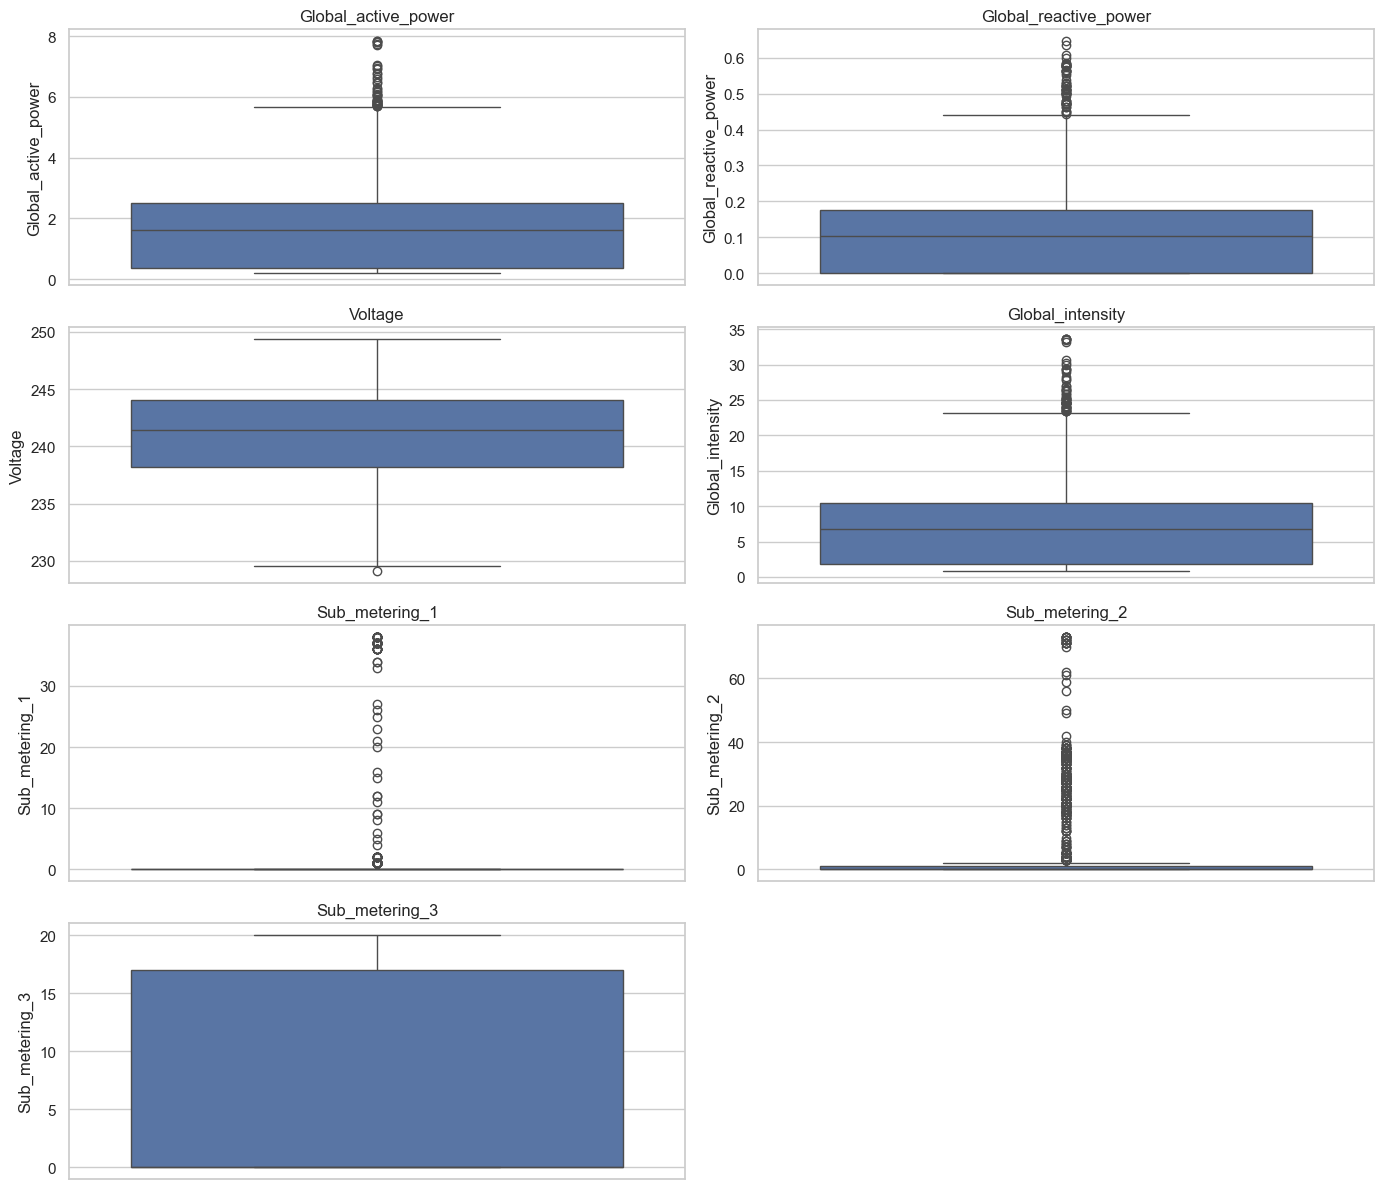

In [8]:
# identify outliers using box plots
plot_boxplots(df=dataset.iloc[:5000], columns=numerical_cols, titles=numerical_cols)

##### Handle outliers by appyling Capping (Winsorizing)

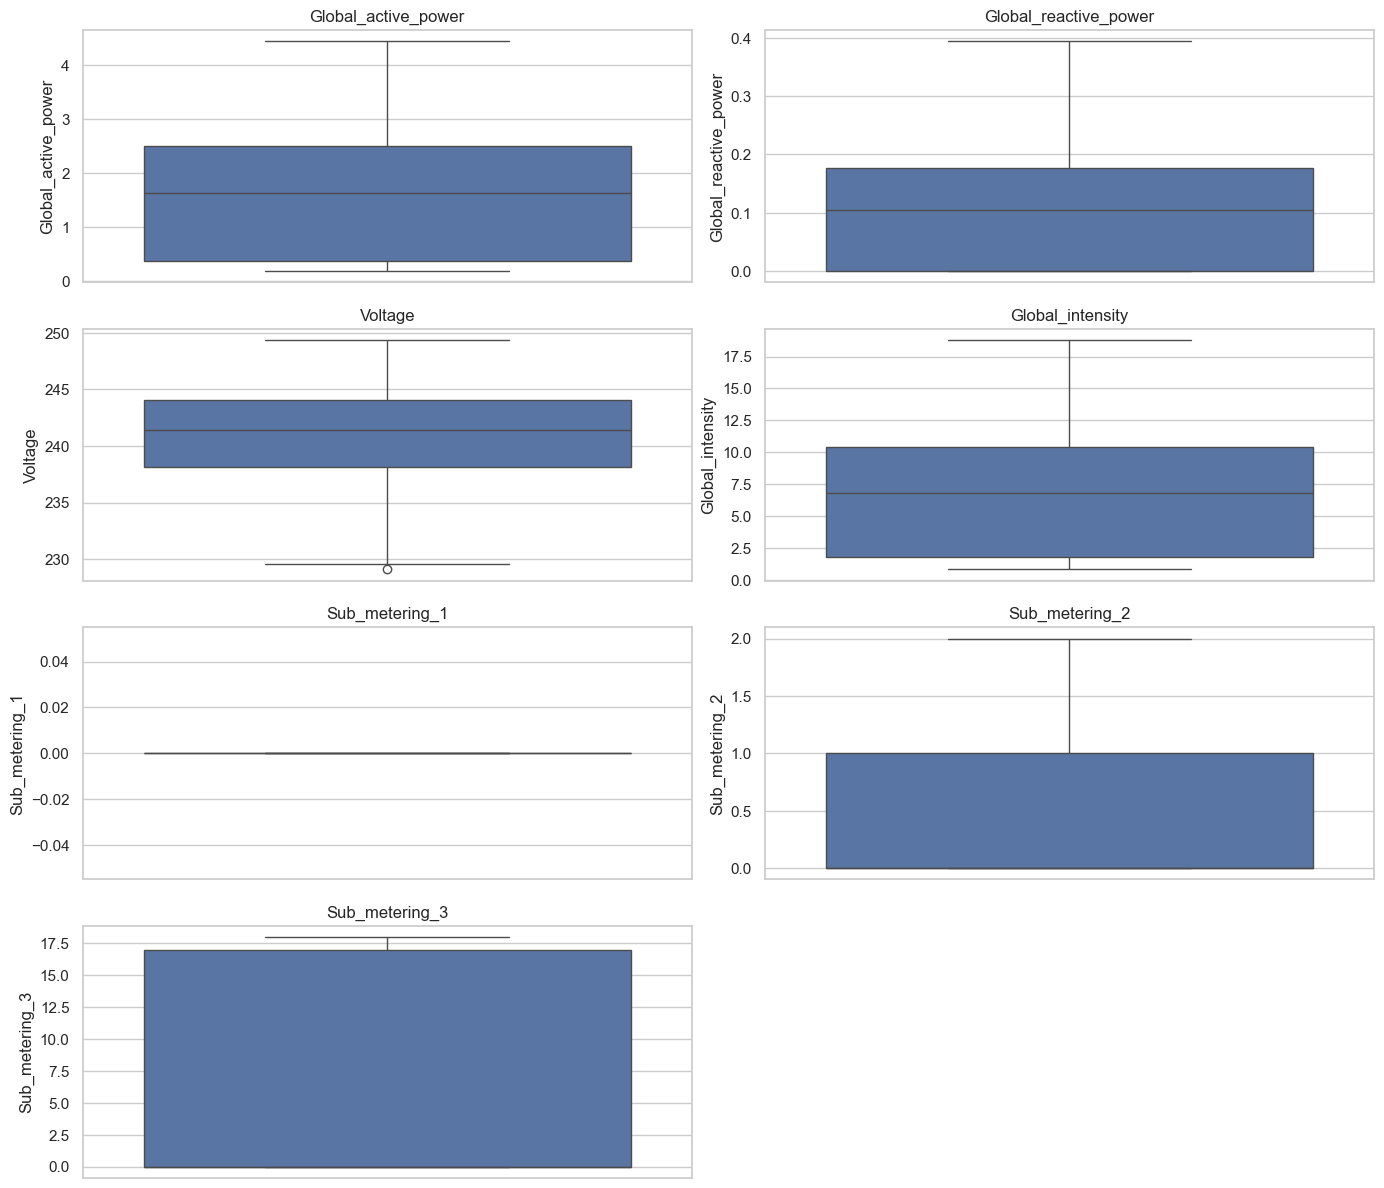

In [9]:
numerical_cols_outliers = numerical_cols.copy()
sub_metering_outliers = ["Sub_metering_1", "Sub_metering_2"]

# remove voltage feature as it doesn't containt outliers
numerical_cols_outliers.remove("Voltage")

numerical_cols_outliers.remove("Sub_metering_1")
numerical_cols_outliers.remove("Sub_metering_2")

cap_outliers(dataset, numerical_cols_outliers, 2, 98)

# Handle sub metering 1 and 2 features separately
cap_outliers(dataset, sub_metering_outliers, 10, 90)

# Verify the changes using Boxplot after capping outliers
plot_boxplots(df=dataset.iloc[:5000], columns=numerical_cols, titles=numerical_cols)

## Exploratory Data Analysis

In [10]:
# Display basic statistics for Global Active Power
global_active_power_stats = dataset['Global_active_power'].describe()
print("Descriptive Statistics for Global Active Power:")
print(global_active_power_stats)

Descriptive Statistics for Global Active Power:
count    496067.000000
mean          1.085675
std           1.086876
min           0.112000
25%           0.274000
50%           0.482000
75%           1.536000
max           4.430000
Name: Global_active_power, dtype: float64


In [11]:
# Convert 'datetime' to datetime type and set as index
dataset['DateTime'] = pd.to_datetime(dataset['DateTime'])
dataset.set_index('DateTime', inplace=True)

### Univariate Analysis

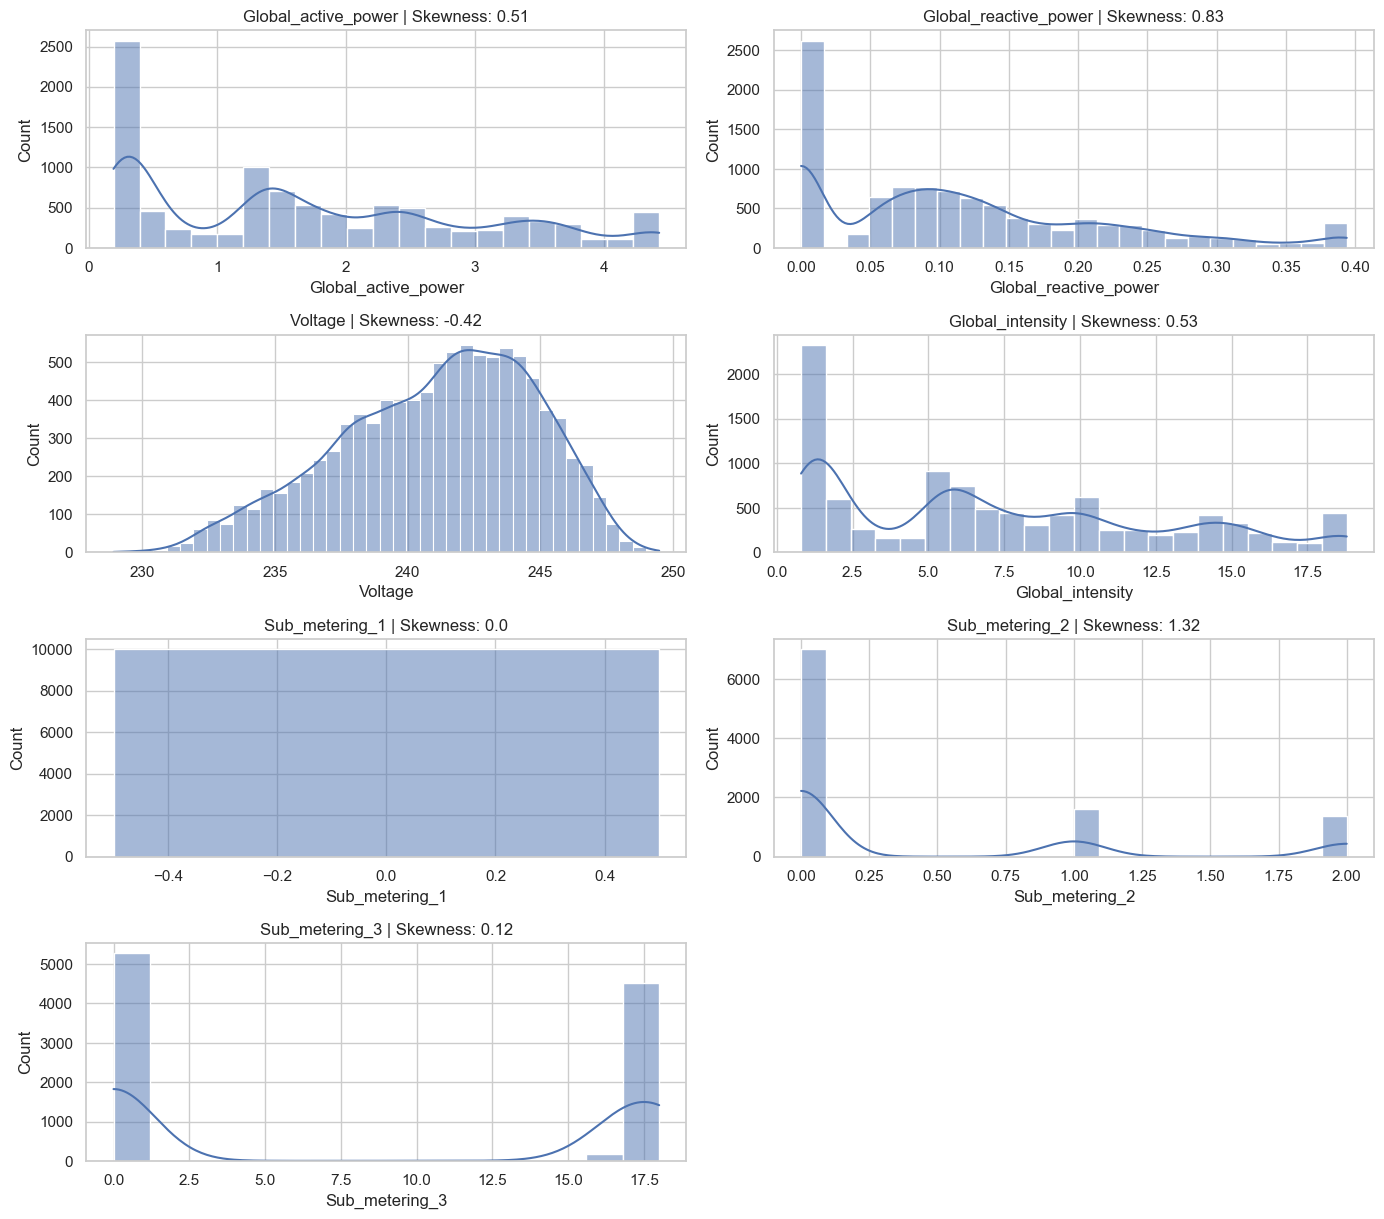

In [15]:
# Plot Histogram with density plot distribution for each numerical feature
plot_histplots(df=dataset.iloc[:10000], columns=numerical_cols, titles=numerical_cols)

### Time Series Analysis

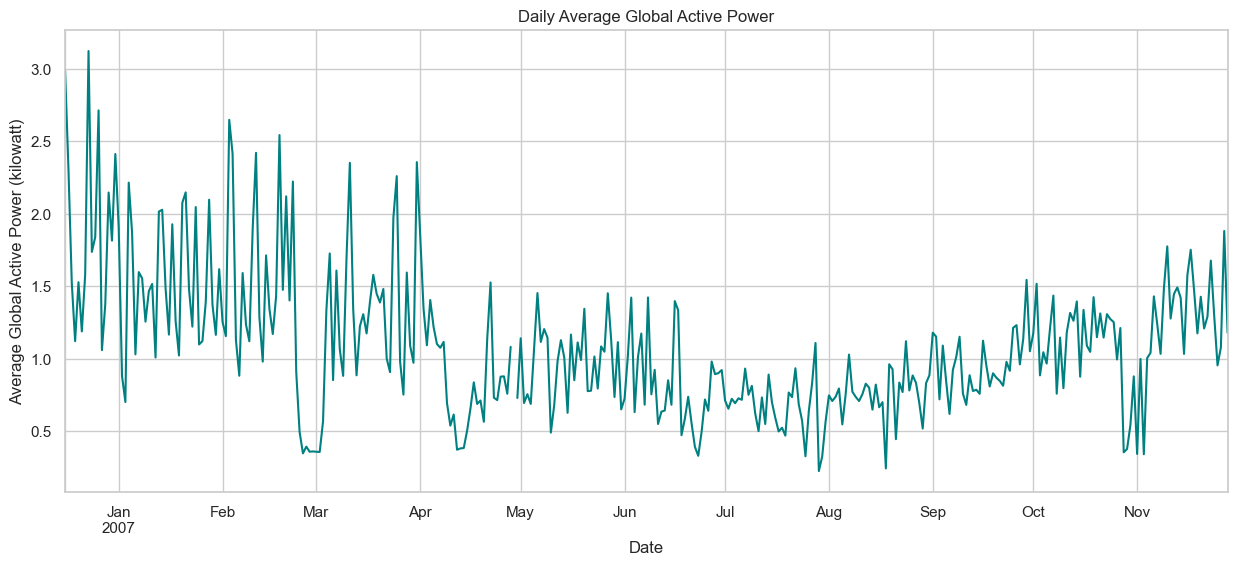

In [50]:
# Resampling to Daily Frequency and Plotting
daily_avg_power = dataset['Global_active_power'].resample('D').mean()

plt.figure(figsize=(15,6))
daily_avg_power.plot(color='teal')
plt.title('Daily Average Global Active Power')
plt.xlabel('Date')
plt.ylabel('Average Global Active Power (kilowatt)')
plt.show()

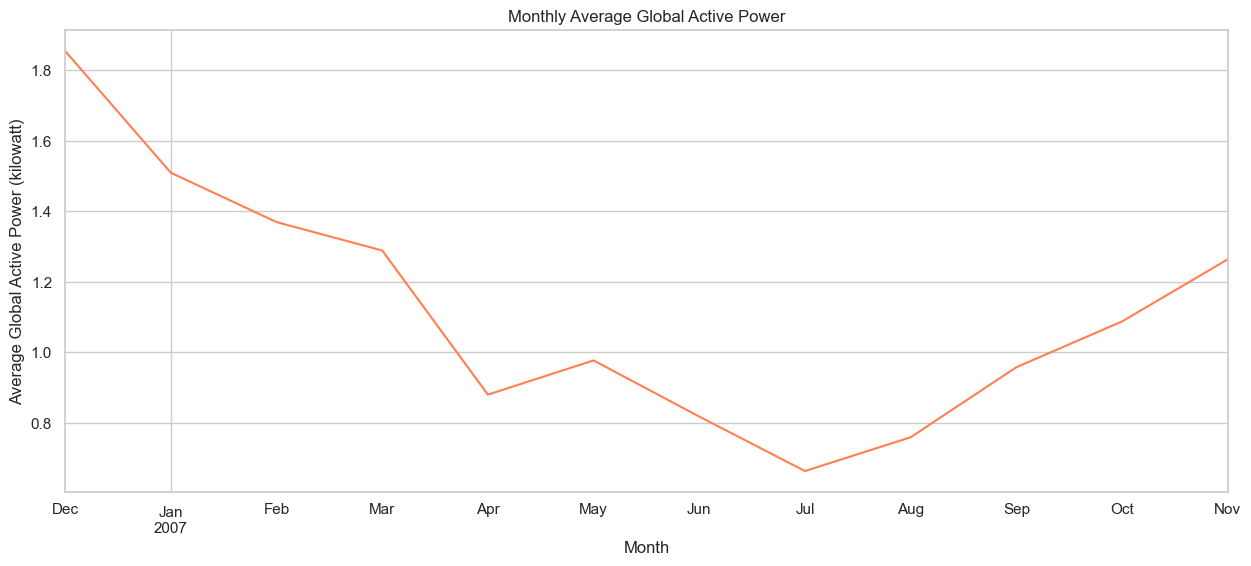

In [51]:
# Resample to monthly frequency and compute mean
monthly_avg_power = dataset['Global_active_power'].resample('ME').mean()

plt.figure(figsize=(15,6))
monthly_avg_power.plot(color='coral')
plt.title('Monthly Average Global Active Power')
plt.xlabel('Month')
plt.ylabel('Average Global Active Power (kilowatt)')
plt.show()

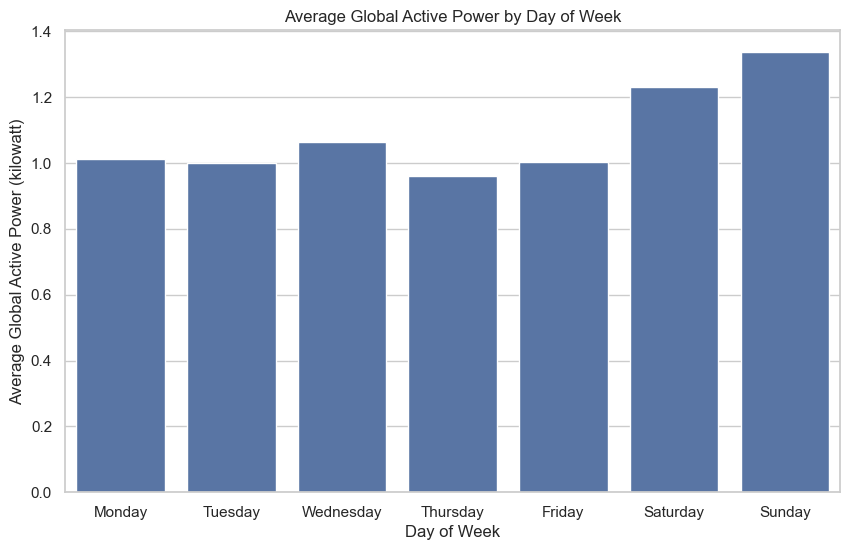

In [52]:
# Extract day of the week (0=Monday, 6=Sunday)
dataset['day_of_week'] = dataset.index.dayofweek

# Compute average consumption per day of the week
weekly_avg_power = dataset.groupby('day_of_week')['Global_active_power'].mean()

# Map day numbers to names
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_avg_power.index = days

plt.figure(figsize=(10,6))
sns.barplot(x=weekly_avg_power.index, y=weekly_avg_power.values)
plt.title('Average Global Active Power by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Global Active Power (kilowatt)')
plt.show()